In [64]:
# Laboratorio de Datos
# Trabajo Práctico Nª 1 
# Integrantes: Román Parisi y Joaquín Núñez

In [65]:
# Importamos las librerías necesarias para el desarrollo del TP:

import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import datetime # Para poder convertir al tipo datetime en el punto 1a
import matplotlib.pyplot as plt

from sklearn import linear_model    
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from formulaic import model_matrix
from formulaic import Formula

In [66]:
# Accedemos al dataset y lo observamos

datos = pd.read_csv("sube-2023.csv")
datos.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO


In [67]:
# Primera Parte: PROCESAMIENTO DE DATOS 

In [68]:
# 1.(a)

datos.dtypes # Visualizamos el tipo de datos de cada columna ("DIA_TRANSPORTE" es de tipo object)
datos["DIA_TRANSPORTE"] = pd.to_datetime(datos["DIA_TRANSPORTE"]) # Transformamos la columna "DIA_TRANSPORTE" al tipo datetime
datos.dtypes # Volvemos a ver el tipo de datos de cada columna y ahora "DIA_TRANSPORTE" es tipo datetime

DIA_TRANSPORTE     datetime64[ns]
NOMBRE_EMPRESA             object
LINEA                      object
AMBA                       object
TIPO_TRANSPORTE            object
JURISDICCION               object
PROVINCIA                  object
MUNICIPIO                  object
CANTIDAD                    int64
DATO_PRELIMINAR            object
dtype: object

In [69]:
# 1.(b)

def dia_de_la_semana(fecha: datetime) -> str:
    return fecha.strftime("%a") # Función para devolver el nombre del día de la semana dado un elemento del tipo datetime 

def fecha_ordinal(fecha: datetime) -> int:
    return int(fecha.strftime("%d")) # Función para devolver el cardinal de la fecha dado un elemento del tipo datetime 

def mes_del_año(fecha: datetime) -> str:
    return fecha.strftime("%m") # Función para devolver el número del mes dado un elemento del tipo datetime 

# Generamos nuevas columnas y les asignamos los datos pedidos utilizando las funciones de arriba

datos["FECHA_DIA"] = datos["DIA_TRANSPORTE"].apply(dia_de_la_semana) 
datos["FECHA_ORDINAL"] = datos["DIA_TRANSPORTE"].apply(fecha_ordinal)
datos["FECHA_MES"] = datos["DIA_TRANSPORTE"].apply(mes_del_año)


In [70]:
# 2.

datos_amba = datos[datos["AMBA"] == "SI"] # Tomamos solo los datos de AMBA
columnas_a_eliminar = ["NOMBRE_EMPRESA", "AMBA", "MUNICIPIO", "DATO_PRELIMINAR", "PROVINCIA", "NOMBRE_EMPRESA"] 
datos_amba.drop(columnas_a_eliminar, axis = 1, inplace = True) # Eliminamos las columnas que no aparecen en la imagen de la consigna
nombre_de_columnas = ["fecha", "fecha_dia", "fecha_mes", "fecha_ordinal", "jurisdiccion", "linea", "pasajeros", "tipo_transporte"] 
datos_amba = datos_amba.rename(columns = {"DIA_TRANSPORTE" : "fecha", "LINEA" : "linea", "TIPO_TRANSPORTE" : "tipo_transporte", "JURISDICCION" : "jurisdiccion", "CANTIDAD" : "pasajeros", "FECHA_DIA" : "fecha_dia", "FECHA_ORDINAL" : "fecha_ordinal", "FECHA_MES" : "fecha_mes"})
# Luego de renombrar las columnas les cambiamos el índice, de esta manera al hacer datos_amba.head() obtendremos lo mismo que se muestra en la consigna
datos_amba = datos_amba.reindex(columns = nombre_de_columnas)
datos_amba.head()

/usr/lib/python3/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Sun,01,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Sun,01,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Sun,01,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Sun,01,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


In [71]:
# 3.(a)

datos_amba["tipo_transporte"].unique() # Vemos los tipos de transporte que hay en nuesto dataframe

# Obtenemos dataframes separados por transporte

colectivos = datos_amba[datos_amba["tipo_transporte"] == "COLECTIVO"] 
trenes = datos_amba[datos_amba["tipo_transporte"] == "TREN"] 
subtes = datos_amba[datos_amba["tipo_transporte"] == "SUBTE"] 

# Tomamos la suma de los pasajeros por transporte y la total

pasajeros_colectivos = np.sum(colectivos["pasajeros"]) 
pasajeros_trenes = np.sum(trenes["pasajeros"])
pasajeros_subtes = np.sum(subtes["pasajeros"])
pasajeros_totales = np.sum(datos_amba["pasajeros"])

# Imprimimos el resultado de dividir la cantidad de pasajeros de cada transporte por la cantidad total, multiplicado por 100 y redondeado a dos dígitos decimales por comodidad

print("PROPORCION ANUAL DE PASAJEROS POR TRANSPORTE EN AMBA:")
print("Colectivo : "+str(round(pasajeros_colectivos/pasajeros_totales*100,2))+"%")
print("Tren : "+str(round(pasajeros_trenes/pasajeros_totales*100,2))+"%")
print("Subte : "+str(round((pasajeros_subtes/pasajeros_totales)*100,2))+"%")
 


PROPORCION ANUAL DE PASAJEROS POR TRANSPORTE EN AMBA:
Colectivo : 83.77%
Tren : 9.42%
Subte : 6.81%


In [72]:
# 3.(b)

max_cant_de_pasajeros = max(subtes["pasajeros"]) 
mes = subtes.loc[subtes["pasajeros"] == max_cant_de_pasajeros, "fecha_mes"].values[0] # Obtenemos el mes cuando hubo la cantidad máxima de pasajeros
linea = subtes.loc[subtes["pasajeros"] == max_cant_de_pasajeros, "linea"].values[0] # Obtenemos la línea de subte donde hubo la cantidad máxima de pasajeros
tupla = (mes,linea) # Generamos la tupla pedida
tupla

('12', 'LINEA_B')

In [73]:
# 3.(c)

datos_dias_habiles = datos_amba[((datos_amba["fecha_dia"] != "Sun") & (datos_amba["fecha_dia"] != "Sat"))] # Filtramos los datos de los días hábiles en un nuevo dataframe
desvio_estandar = datos_dias_habiles.groupby("fecha_dia")["pasajeros"].std() # Utilizamos la funcion std() de python para obtener el desvío estándar de todos los días 
desvio_estandar.idxmin() # Tomamos el índice del valor mínimo con idxmin()

'Mon'

In [74]:
# Segunda Parte: ANÁLISIS EXPLORATORIO

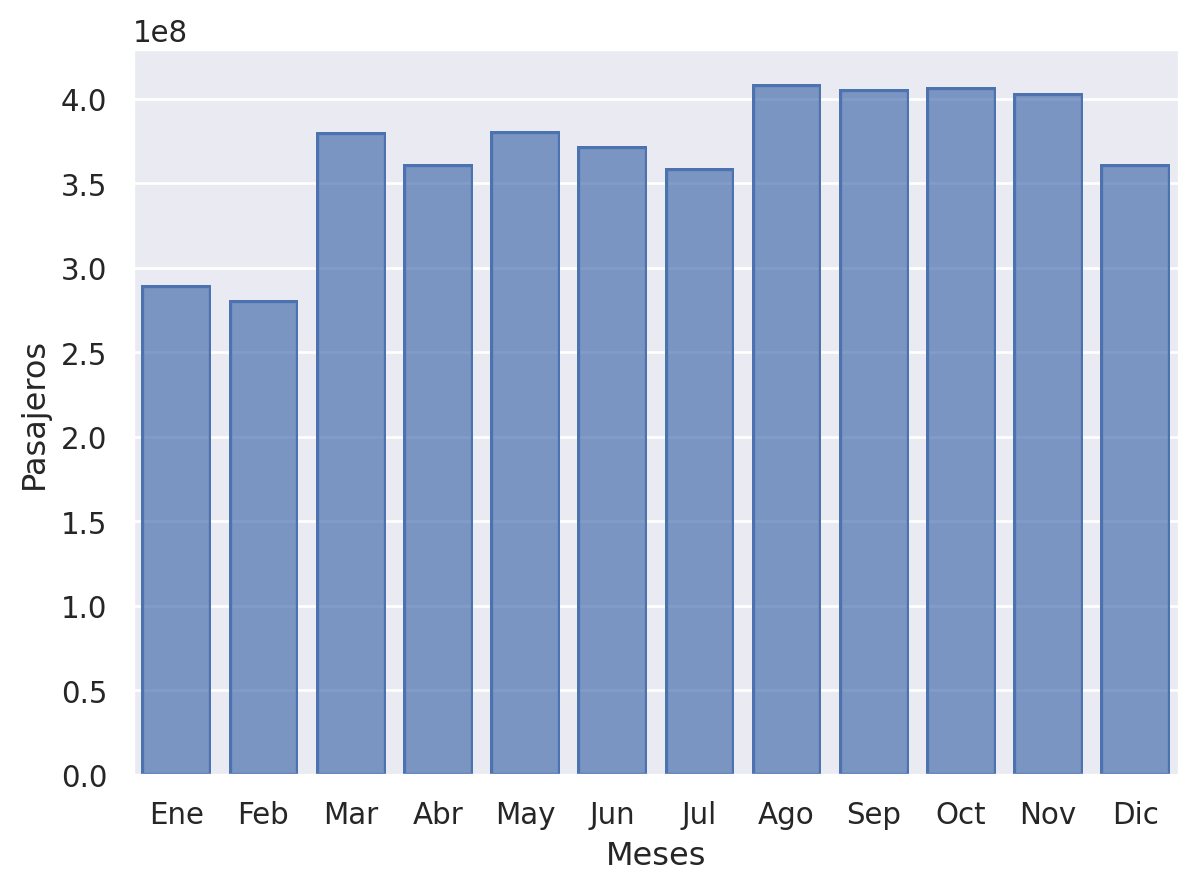

In [75]:
# 4.

# Vamos a analizar la cantidad de pasajeros por tipo de transporte a lo largo del año, para ver si varía la proporción y tratar de obtener alguna conclusión al respécto.

# Primero limpiamos los datos como hicimos en la Primera Parte para datos_amba

datos_limpios = datos
datos_limpios.drop(columnas_a_eliminar, axis = 1, inplace = True)
datos_limpios = datos_limpios.rename(columns = {"DIA_TRANSPORTE" : "fecha", "LINEA" : "linea", "TIPO_TRANSPORTE" : "tipo_transporte", "JURISDICCION" : "jurisdiccion", "CANTIDAD" : "pasajeros", "FECHA_DIA" : "fecha_dia", "FECHA_ORDINAL" : "fecha_ordinal", "FECHA_MES" : "fecha_mes"})
datos_limpios = datos_limpios.reindex(columns = nombre_de_columnas)

# 

pasajeros_por_mes = datos_limpios.groupby("fecha_mes")["pasajeros"].sum()
datos_analisis_exploratorio_meses = {
    "Meses":["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"],
    "Pasajeros":[pasajeros_por_mes["01"], pasajeros_por_mes["02"], pasajeros_por_mes["03"], pasajeros_por_mes["04"], pasajeros_por_mes["05"], pasajeros_por_mes["06"], pasajeros_por_mes["07"], pasajeros_por_mes["08"], pasajeros_por_mes["09"], pasajeros_por_mes["10"], pasajeros_por_mes["11"], pasajeros_por_mes["12"]]
} 

pasajeros_por_tipo_transporte = datos_limpios.groupby("tipo_transporte")["pasajeros"].sum()
datos_analisis_exploratorio_transporte = {
    "Transporte":["Colectivo", "Lanchas", "Subte", "Tren"],
    "Pasajeros":[pasajeros_por_tipo_transporte["COLECTIVO"], pasajeros_por_tipo_transporte["LANCHAS"], pasajeros_por_tipo_transporte["SUBTE"], pasajeros_por_tipo_transporte["TREN"]]
}

so.Plot(data=datos_analisis_exploratorio_meses, x="Meses", y="Pasajeros").add(so.Bar())
#so.Plot(data=datos_analisis_exploratorio_transporte, x="Transporte", y="Pasajeros").add(so.Bar())

In [88]:
g = datos_limpios.groupby(["fecha_mes", "tipo_transporte"])["pasajeros"].sum()
# g['01', 'COLECTIVO']
nuevo_df = pd.DataFrame(
    {"mes": [indice[0] for indice in g.index], 
    "tipo_transporte": [indice[1] for indice in g.index], 
    "pasajeros": [g[indice] for indice in g.index]}
    )
nuevo_df

,mes,tipo_transporte,pasajeros
0,01,COLECTIVO,248922245
1,01,LANCHAS,1206
2,01,SUBTE,16056151
3,01,TREN,24692542
4,02,COLECTIVO,242650659
5,02,LANCHAS,1071
6,02,SUBTE,15553011
7,02,TREN,22500303
8,03,COLECTIVO,332572496
9,03,LANCHAS,1325


In [80]:
so.Plot(data=, x="Meses", y="Pasajeros").add(so.Bar())

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.